## Bonus

In [44]:
# IMPORTS"
%matplotlib inline 
from pprint import pprint
from collections import Counter
import random
import time
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import islice
from collections import defaultdict
import queue as q
from random import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import itertools

In [2]:
scenario_10 = 'scenario10.labeled'


def parse_line(split_line):
    src = split_l[3].split(':')
    dst = split_l[5].split(':')

    return {
        'datetime': split_l[0],
        'duration': split_l[1],
        'protocol': split_l[2],
        'src_ip': src[0],
        'src_port': '' if len(src) == 1 else src[1],
        'dst_ip': dst[0],
        'dst_port': '' if len(dst) == 1 else src[1],
        'flags': split_l[6],
        'tos': split_l[7],
        'packets': int(split_l[8]),
        'bytes': int(split_l[9]),
        'flows': split_l[10],
        'label': split_l[11][:-1]
    }

parsed = []
with open('Data/{}'.format(scenario_10)) as f:                                
    next(f) # Skip header
    for idx, l in enumerate(f):
        try:
            split_l = list(filter(None, l.split('\t')))
            parsed.append(parse_line(l))
        except Exception as e:
#             print('ERROR on line {}, raw string {}, splitted as {}'.format(idx, l, split_l))
            try:
#                 print('Attempting to pars with space as dividing character...')
                split_l = list(filter(None, l.split(' ')))
                split_l[0:2] = [' '.join(split_l[0:2])] # Merge date and time again
                parsed.append(parse_line(l))
            except Exception as e:
                print('Final ERROR, skipping line, splitted as {}, error {}'.format(split_l, e))

In [3]:
pprint(parsed[-1])

{'bytes': 17998,
 'datetime': '2011-08-18 15:04:59.743',
 'dst_ip': '147.32.84.21',
 'dst_port': '80',
 'duration': '0.001',
 'flags': 'PA_',
 'flows': '1',
 'label': 'Background',
 'packets': 14,
 'protocol': 'TCP',
 'src_ip': '64.174.237.178',
 'src_port': '80',
 'tos': '0'}


In [4]:
scenario_data = pd.DataFrame.from_records(parsed)
scenario_data['datetime'] = pd.to_datetime(scenario_data['datetime'])
scenario_data.set_index(['datetime'], inplace=True)
scenario_data = scenario_data[scenario_data.label != 'Background']
scenario_data

,bytes,dst_ip,dst_port,duration,flags,flows,label,packets,protocol,src_ip,src_port,tos
datetime,,,,,,,,,,,,
2011-08-18 10:19:13.347,86277,147.32.85.88,80,4.985,PA_,1,LEGITIMATE,91,TCP,147.32.80.13,80,0
2011-08-18 10:19:13.392,66,74.125.232.214,48102,0.000,A_,1,LEGITIMATE,1,TCP,147.32.86.110,48102,0
2011-08-18 10:19:13.411,3234,147.32.80.13,56949,4.921,A_,1,LEGITIMATE,49,TCP,147.32.85.88,56949,0
2011-08-18 10:19:13.460,7080,74.125.108.208,2768,4.742,A_,1,LEGITIMATE,118,TCP,147.32.84.59,2768,0
2011-08-18 10:19:13.486,60,74.125.232.215,56058,0.000,A_,1,LEGITIMATE,1,TCP,147.32.84.59,56058,0
2011-08-18 10:19:13.689,1980,195.24.232.164,34588,4.434,A_,1,LEGITIMATE,30,TCP,147.32.84.164,34588,0
2011-08-18 10:19:13.848,66,74.125.232.215,53538,0.000,A_,1,LEGITIMATE,1,TCP,147.32.86.110,53538,0
2011-08-18 10:19:13.858,559,74.125.232.215,37578,0.174,PA_,1,LEGITIMATE,5,TCP,147.32.84.59,37578,0
2011-08-18 10:19:14.067,120,209.85.148.147,58763,0.009,FA_,1,LEGITIMATE,2,TCP,147.32.85.26,58763,0


In [5]:
scenario_data['label'] = scenario_data['label'].astype('category')
# scenario_data['label'].cat.codes
scenario_data.groupby('label').count()

,bytes,dst_ip,dst_port,duration,flags,flows,packets,protocol,src_ip,src_port,tos
label,,,,,,,,,,,
Botnet,323410,323410,323410,323410,323410,323410,323410,323410,323410,323410,323410
Botnet,31,31,31,31,31,31,31,31,31,31,31
LEGITIMATE,321917,321917,321917,321917,321917,321917,321917,321917,321917,321917,321917


In [6]:
# Throw away this weird identical duplicate
scenario_data = scenario_data[scenario_data['label'].cat.codes != 1]
scenario_data.groupby('label').count()

,bytes,dst_ip,dst_port,duration,flags,flows,packets,protocol,src_ip,src_port,tos
label,,,,,,,,,,,
Botnet,323410,323410,323410,323410,323410,323410,323410,323410,323410,323410,323410
Botnet,0,0,0,0,0,0,0,0,0,0,0
LEGITIMATE,321917,321917,321917,321917,321917,321917,321917,321917,321917,321917,321917


In [30]:
merged = pd.get_dummies(scenario_data['protocol']).values
merged = np.column_stack((merged, pd.get_dummies(scenario_data['flags']).values))
merged = np.column_stack((merged, scenario_data['packets'].values))
merged = np.column_stack((merged, scenario_data['bytes'].values))
print(merged)
print(merged.shape)

[[    0     1     0 ...     0    91 86277]
 [    0     1     0 ...     0     1    66]
 [    0     1     0 ...     0    49  3234]
 ...
 [    1     0     0 ...     0     1  1066]
 [    0     1     0 ...     0     2   359]
 [    1     0     0 ...     0     1  1066]]
(645327, 83)


In [35]:
scenario_data['src_ip']

datetime
2011-08-18 10:19:13.347     147.32.80.13
2011-08-18 10:19:13.392    147.32.86.110
2011-08-18 10:19:13.411     147.32.85.88
2011-08-18 10:19:13.460     147.32.84.59
2011-08-18 10:19:13.486     147.32.84.59
2011-08-18 10:19:13.689    147.32.84.164
2011-08-18 10:19:13.848    147.32.86.110
2011-08-18 10:19:13.858     147.32.84.59
2011-08-18 10:19:14.067     147.32.85.26
2011-08-18 10:19:14.134     147.32.84.21
2011-08-18 10:19:14.257    147.32.86.166
2011-08-18 10:19:14.292    147.32.85.124
2011-08-18 10:19:14.454     147.32.84.59
2011-08-18 10:19:14.502      147.32.85.5
2011-08-18 10:19:14.683    147.32.86.147
2011-08-18 10:19:14.684    147.32.86.147
2011-08-18 10:19:15.145     147.32.84.59
2011-08-18 10:19:15.145     147.32.84.59
2011-08-18 10:19:15.145     147.32.84.59
2011-08-18 10:19:15.145     147.32.84.59
2011-08-18 10:19:15.323    147.32.84.164
2011-08-18 10:19:15.335     147.32.85.60
2011-08-18 10:19:15.368     147.32.80.13
2011-08-18 10:19:15.523      147.32.84.3
2011-08

In [42]:
def cross_validate(clf, x_test, y_test, ip_s):
    y_predict = clf.predict(x_test)

    ##
    #
    # FLOW BASED
    #
    ##
    TP, FP, FN, TN = 0, 0, 0, 0
    for i in range(len(y_predict)):
        if y_test[i] == 0 and y_predict[i] == 0:
            TP += 1
        if y_test[i] == 2 and y_predict[i] == 0:
            FP += 1
        if y_test[i] == 0 and y_predict[i] == 2:
            FN += 1
        if y_test[i] == 2 and y_predict[i] == 2:
            TN += 1

    print('TP: {}'.format(TP))
    print('FP: {}'.format(FP))
    print('FN: {}'.format(FN))
    print('TN: {}'.format(TN))

    
    ##
    #
    # HOST BASED
    #
    ##
    treshhold = 20
    
    host_count = defaultdict(lambda: 0)
    for idx, ip in enumerate(ip_s):
        if y_test[idx] == 0:
            host_count[ip] += 1

    predicted_infected_hosts = []
    for ip, count in host_count.items():
        if count > treshhold:
            predicted_infected_hosts.append(ip)
    
    
    infected_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204', '147.32.84.205', 
                 '147.32.84.206', '147.32.84.207', '147.32.84.208', '147.32.84.209']
    
    tp, fp, tn, fn = 0, 0, 0, 0
    for predicted in predicted_infected_hosts:
        if predicted in infected_hosts:
            tp += 1
        elif predicted not in infected_hosts:
            fp += 1

    for real in infected_hosts:
        if real not in predicted_infected_hosts:
            fn += 1

    tn = 50000 - tp - fp - fn
    
    
    return TP, FP, FN, TN, tp, fp, fn, tn

# Split the dataset in train and test set
x = merged
print(x.shape)
y = scenario_data['label'].cat.codes.values
print(y.shape)
print(scenario_data['label'].shape)

TP_total, FP_total, FN_total, TN_total = 0, 0, 0, 0
tp_total, fp_total, fn_total, tn_total = 0, 0, 0, 0
fold_n = 1

kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(x):
    print('Split data in train and test')
    x_train = x[train_index]
    x_test = x[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    ip_s = scenario_data['src_ip'].values[test_index]

    print('Starting to train classifier')
    clf = RandomForestClassifier(n_jobs=6)
    clf.fit(x_train, y_train)
    
    TP, FP, FN, TN, tp, fp, fn, tn = cross_validate(clf, x_test, y_test, ip_s)

    TP_total += TP
    FP_total += FP
    FN_total += FN
    TN_total += TN

    tp_total += tp
    fp_total += fp
    fn_total += fn
    tn_total += tn
    
    fold_n += 1
    print(fold_n)

print('----- Total summed folds flow based:')
print('TP: {}'.format(TP_total))
print('FP: {}'.format(FP_total))
print('FN: {}'.format(FN_total))
print('TN: {}'.format(TN_total))

print('----- Total summed folds host based:')
print('TP: {}'.format(tp_total))
print('FP: {}'.format(fp_total))
print('FN: {}'.format(fn_total))
print('TN: {}'.format(tn_total))

(645327, 83)
(645327,)
(645327,)
Split data in train and test
Starting to train classifier
TP: 32073
FP: 47
FN: 330
TN: 32083
2
Split data in train and test
Starting to train classifier
TP: 32063
FP: 51
FN: 329
TN: 32090
3
Split data in train and test
Starting to train classifier
TP: 32139
FP: 39
FN: 329
TN: 32026
4
Split data in train and test
Starting to train classifier
TP: 32106
FP: 32
FN: 318
TN: 32077
5
Split data in train and test
Starting to train classifier
TP: 31901
FP: 48
FN: 331
TN: 32253
6
Split data in train and test
Starting to train classifier
TP: 31871
FP: 52
FN: 317
TN: 32293
7
Split data in train and test
Starting to train classifier
TP: 31944
FP: 46
FN: 327
TN: 32216
8
Split data in train and test
Starting to train classifier
TP: 32114
FP: 46
FN: 311
TN: 32061
9
Split data in train and test
Starting to train classifier
TP: 32020
FP: 43
FN: 324
TN: 32145
10
Split data in train and test
Starting to train classifier
TP: 31955
FP: 36
FN: 308
TN: 32233
11
----- Total sum

Confusion matrix, without normalization
[[321477   3224]
 [   440 320186]]
Confusion matrix, without normalization
[[499874      0]
 [    26    100]]


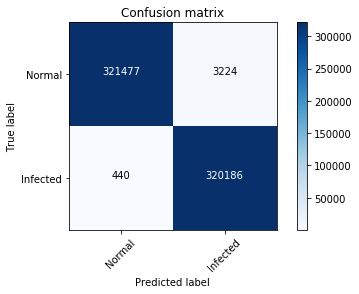

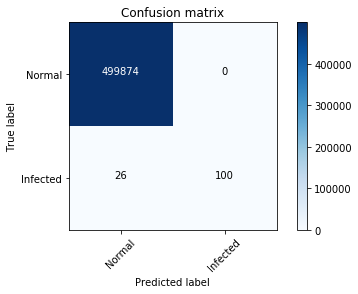

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(np.array([[TN_total, FN_total], [FP_total, TP_total]]), ['Normal', 'Infected'])

plt.figure()
plot_confusion_matrix(np.array([[tn_total, fn_total], [fp_total, tp_total]]), ['Normal', 'Infected'])